### Recurrent Neural Networks

Here we return to our original sequence of historical load data without pivot
the prior hours' data into features as was needed with the regression
techniques.

Moreover, we will not immediately employ the walkforward validation technique due to the time cost of daily retraining. Instead we will train the model to always predict 24 hours out. This simplifies our train/validation/test split as well.

#### TODO predict 1 to 24 hours out

We should train seperate models that predict each of the subsequent 24 hours. These 24 models can be trained independently of each other. This would allow us to train on data that is more recent in the sequence. The hour-ending 24 model will still be trained as above, but the other hours will have a smaller `delay`... but we need the hourly prediction for a particular hour... this approach would just give a "good at `n` hours out" model across the entire day. We could train 1-hour-out models, then do walk forward validation as before...feeding the hourly prediction into the sequence 

In [1]:
%load_ext autoreload
%autoreload 2

from datasets import DataSet

ds = DataSet('data/zone1_rst.parquet', mtlf='LRZ1 MTLF (MWh)', actual='LRZ1 ActualLoad (MWh)')
ds.data.head()

,MSP,RST,LRZ1 MTLF (MWh),LRZ1 ActualLoad (MWh)
hour,,,,
2015-02-01 00:00:00-05:00,23.00,24.08,11099,11337.89
2015-02-01 01:00:00-05:00,21.02,24.08,10829,11014.87
2015-02-01 02:00:00-05:00,19.04,23.00,10565,10795.37
2015-02-01 03:00:00-05:00,19.04,19.94,10468,10714.42
2015-02-01 04:00:00-05:00,17.06,19.04,10432,10700.09


Since we are predicting 24 hours out, it is acceptable to incorporate the temperature data again, but we will need to normalize. We also will drop our categoricals for now. Can an RNN learn a good model for predicting tomorrow's load from just prior load and temperature sequences? Should we incorporate more temperature sequences?

In [2]:
features = ['MSP', 'RST', ds.actual]
df = ds.data[features].copy()
load = ds.data[ds.actual].copy()

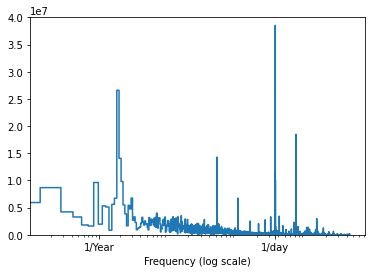

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

fft = tf.signal.rfft(load)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(load)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [4]:
f_per_year[np.argwhere(np.abs(fft) > 1e7).flatten()]

array([  0.        ,   1.95471468,   2.09433716,  52.21880642,
       364.27504266, 365.2524    , 366.22975734, 730.5048    ])

Create yearly, weekly, and daily signals.

In [5]:
import pandas as pd
day = 24*60*60
year = (365.2425)*day
timestamp_s = df.index.to_series().map(pd.Timestamp.timestamp)
df['Daily sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Daily cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Weekly sin'] = np.sin(timestamp_s * (2 * np.pi / (7*day)))
df['Weekly cos'] = np.cos(timestamp_s * (2 * np.pi / (7*day)))
df['Yearly sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Yearly cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

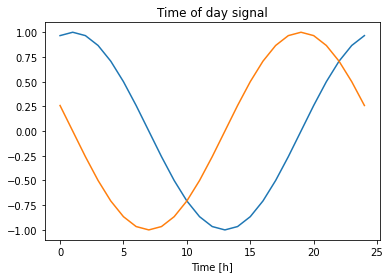

In [6]:
plt.plot(np.array(df['Daily sin'])[:25])
plt.plot(np.array(df['Daily cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [7]:
num_features = df.shape[1]
df.head()

,MSP,RST,LRZ1 ActualLoad (MWh),Daily sin,Daily cos,Weekly sin,Weekly cos,Yearly sin,Yearly cos
hour,,,,,,,,,
2015-02-01 00:00:00-05:00,23.00,24.08,11337.89,0.965926,2.588190e-01,0.258819,-0.965926,0.512742,0.858543
2015-02-01 01:00:00-05:00,21.02,24.08,11014.87,1.000000,-9.564734e-13,0.222521,-0.974928,0.513357,0.858175
2015-02-01 02:00:00-05:00,19.04,23.00,10795.37,0.965926,-2.588190e-01,0.185912,-0.982566,0.513972,0.857807
2015-02-01 03:00:00-05:00,19.04,19.94,10714.42,0.866025,-5.000000e-01,0.149042,-0.988831,0.514587,0.857438
2015-02-01 04:00:00-05:00,17.06,19.04,10700.09,0.707107,-7.071068e-01,0.111964,-0.993712,0.515201,0.857069


In [8]:
num_test_samples = num_val_samples = 365 * 24
num_train_samples = df.shape[0] - num_test_samples - num_val_samples

train_df = df.iloc[:num_train_samples]
val_df = df.iloc[num_train_samples:num_train_samples + num_val_samples]
test_df = df.iloc[num_train_samples + num_val_samples:]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

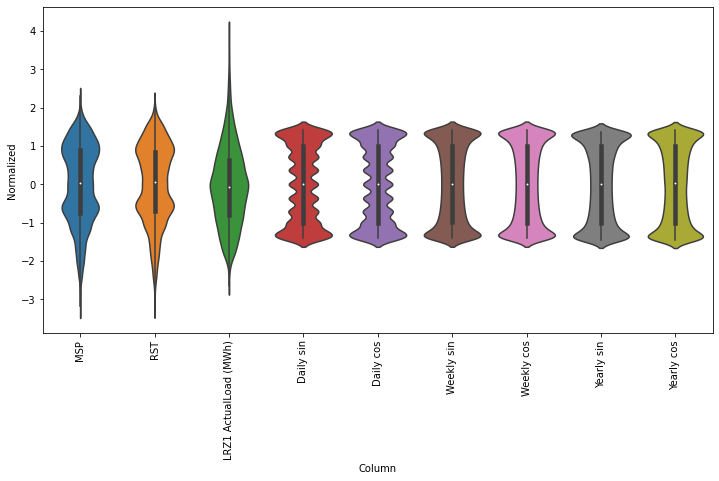

In [9]:
import seaborn as sns
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [32]:
from validation import WindowGenerator
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from keras import layers

MAX_EPOCHS = 20

def compile_and_fit(model, window : WindowGenerator, patience=5, optimizer="adamax", loss="mse",
                    epochs=MAX_EPOCHS, checkpoint_file=None):

    ts = datetime.now().strftime ("%Y%m%d_%H%M%S")
    checkpoint_file = checkpoint_file or f"load_prediction_{optimizer}_{loss}_{ts}.keras"
    print(f"Saving checkpoints to {checkpoint_file}")

    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_file, monitor='val_mae', save_best_only=True, save_weights_only=True),
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=patience)]
    model.compile(optimizer=optimizer, loss=loss, metrics=["mae"])

    history = model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=callbacks)
    print(f"Best model saved to {checkpoint_file}")
    return history


In [39]:
# by default predict a single hour a full day ahead based on previous eight days
def window(input_width=24*8, label_width=1, shift=24, label_columns=[ds.actual]):
    return WindowGenerator(input_width=input_width, label_width=label_width, shift=shift,
                           train_df=train_df, val_df=val_df, test_df=test_df,
                           label_columns=label_columns)

OUT_STEPS = 24
multi_window = window(input_width=24*8, label_width=OUT_STEPS, shift=OUT_STEPS)

In [23]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.layer1 = layers.Dense(32, activation='leaky_relu')
    self.layer2 = layers.LSTMCellV2(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)
    self.layer3 = layers.LSTMCellV2(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)
    self.layer4 = layers.LSTMCellV2(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)
    self.layer5 = layers.Dropout(0.25)
    self.layer6 = layers.Dense(32, activation='leaky_relu')
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step.
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output.
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

In [24]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 9)


In [40]:
history = compile_and_fit(feedback_model, multi_window)

Saving checkpoints to load_prediction_adamax_mse_20220507_093545.keras
Epoch 1/20
1408/1408 [==============================] - 36s 24ms/step - loss: 0.0584 - mae: 0.1770 - val_loss: 0.1218 - val_mae: 0.2569
Epoch 2/20
1408/1408 [==============================] - 34s 24ms/step - loss: 0.0580 - mae: 0.1764 - val_loss: 0.1187 - val_mae: 0.2550
Epoch 3/20
1408/1408 [==============================] - 34s 24ms/step - loss: 0.0572 - mae: 0.1751 - val_loss: 0.1176 - val_mae: 0.2524
Epoch 4/20
1408/1408 [==============================] - 34s 24ms/step - loss: 0.0566 - mae: 0.1743 - val_loss: 0.1206 - val_mae: 0.2546
Epoch 5/20
1408/1408 [==============================] - 34s 24ms/step - loss: 0.0562 - mae: 0.1739 - val_loss: 0.1209 - val_mae: 0.2532
Epoch 6/20
1408/1408 [==============================] - 35s 25ms/step - loss: 0.0555 - mae: 0.1730 - val_loss: 0.1193 - val_mae: 0.2512
Epoch 7/20
1408/1408 [==============================] - 34s 24ms/step - loss: 0.0545 - mae: 0.1717 - val_loss: 0.

In [34]:
feedback_model.evaluate(multi_window.test, verbose=0)

[0.13344496488571167, 0.26609453558921814]

In [38]:
0.26609453558921814 * train_std[2] + train_mean[2]

11551.522559735093

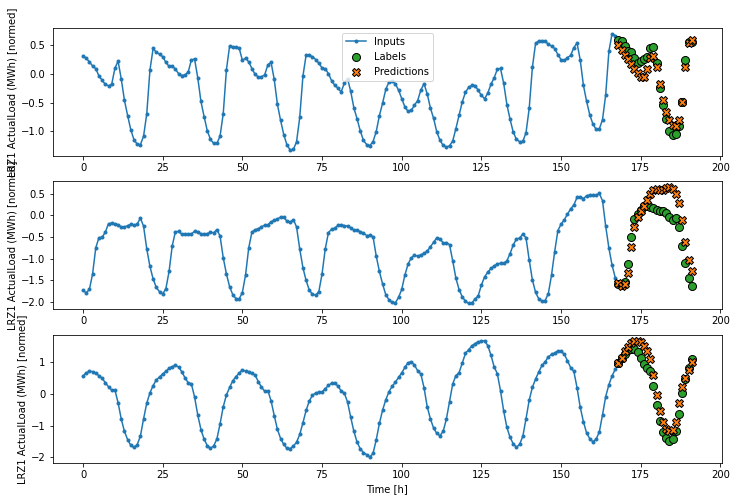

In [36]:

multi_window.plot(feedback_model)

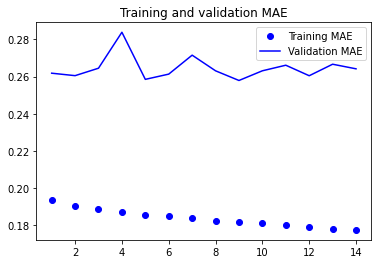

In [37]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()